# Load Libraries for Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
import os

plt.rcParams.update({
'figure.figsize': (6, 6),
'figure.dpi': 300,
'axes.spines.top': False,
'axes.spines.right': False,
'axes.linewidth': 1.0,
'axes.prop_cycle': plt.cycler(color='kbrgymc'),
'font.family': 'Helvetica Neue',
'font.size': 20,
'legend.frameon': 'false',
})

/Users/ryanhigginbotham/anaconda3/envs/dataAnalysis/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Constants

In [2]:
DATA_DIR = "data/experiment1"
REPS = 30
DELAYS = [5, 10, 20, 40, 60, 80, 100, 120, 160]

# Equations

In [3]:
def sigmoid(x, a, b, c, d):
    return a / (1 + np.exp(-(b * (x - c))))+d

# Functions

In [4]:
def estimate_indifference_delay(obtained_delays: np.ndarray, props: np.ndarray) -> float:
    """
    Estimates the indifference delay given obtained larger later delay and proportion of choices for the larger later option
    """
    params, _ = curve_fit(sigmoid, obtained_delays, props, p0=[-0.9, 0.05, 100, 1], maxfev=1000000)

    estimation_x = np.linspace(min(obtained_delays), max(obtained_delays), 10000)
    estimation_y = sigmoid(estimation_x, *params)

    indiff_pt = estimation_x[np.argmin(np.abs(estimation_y - 0.5))]

    return indiff_pt

# Load the Data

In [5]:
dfs = []

files = [f for f in os.listdir(DATA_DIR) if f.endswith(".xlsx")]

for file in files:
    for rep in range(1, REPS+1):
        df = pd.read_excel(f"{DATA_DIR}/{file}", sheet_name=f"Repetition {rep}")
        df["Rep"] = rep
        df["File"] = file
        df["SSDelay"] = int(file.split("_")[2].replace("ssd", "").replace(".xlsx", "")) # assumes the file name format follows what is in the data directory
        df["LLDelay"] = df["Sched"].apply(lambda x: DELAYS[x-1])

        dfs.append(df)

df = pd.concat(dfs)

df

,Sched,P1,R1,B1,P2,R2,B2,Rep,File,SSDelay,LLDelay
0,1,0,1,1,0,68,230,1,adj_del_ssd40.xlsx,40,5
1,1,0,0,0,0,71,231,1,adj_del_ssd40.xlsx,40,5
2,1,0,2,8,0,62,196,1,adj_del_ssd40.xlsx,40,5
3,1,0,0,0,0,76,206,1,adj_del_ssd40.xlsx,40,5
4,1,0,0,0,0,78,245,1,adj_del_ssd40.xlsx,40,5
...,...,...,...,...,...,...,...,...,...,...,...
364,9,0,3,24,0,2,44,30,adj_del_ssd30.xlsx,30,160
365,9,0,12,63,0,1,15,30,adj_del_ssd30.xlsx,30,160
366,9,0,7,84,0,2,9,30,adj_del_ssd30.xlsx,30,160
367,9,0,8,68,0,0,2,30,adj_del_ssd30.xlsx,30,160


# Clean the Data

In [6]:
# remove the first row (500 gens) for each file, for each rep, for each sched
clean_df = df.groupby(["File", "Rep", "Sched"]).apply(lambda x: x.iloc[1:]).reset_index(drop=True)

clean_df

/var/folders/cq/0qrgb7j93zv58kqbskvwx4t00000gn/T/ipykernel_68450/652372700.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  clean_df = df.groupby(["File", "Rep", "Sched"]).apply(lambda x: x.iloc[1:]).reset_index(drop=True)


,Sched,P1,R1,B1,P2,R2,B2,Rep,File,SSDelay,LLDelay
0,1,0,0,0,0,59,213,1,adj_del_ssd10.xlsx,10,5
1,1,0,0,0,0,73,229,1,adj_del_ssd10.xlsx,10,5
2,1,0,1,1,0,68,220,1,adj_del_ssd10.xlsx,10,5
3,1,0,0,0,0,82,261,1,adj_del_ssd10.xlsx,10,5
4,1,0,0,0,0,73,245,1,adj_del_ssd10.xlsx,10,5
...,...,...,...,...,...,...,...,...,...,...,...
64795,9,0,6,50,0,1,13,30,adj_del_ssd60.xlsx,60,160
64796,9,0,7,69,0,2,9,30,adj_del_ssd60.xlsx,60,160
64797,9,0,2,29,0,2,34,30,adj_del_ssd60.xlsx,60,160
64798,9,0,2,23,0,4,40,30,adj_del_ssd60.xlsx,60,160


# Individual AO Data

In [7]:
ind_ao_df = clean_df.groupby(["File", "Rep", "Sched"]).mean().reset_index()

ind_ao_df["PropLL"] = ind_ao_df["B2"] / (ind_ao_df["B1"] + ind_ao_df["B2"])
ind_ao_df["ObtainedLLDelay"] = 500/ind_ao_df["R2"]

ind_ao_df

,File,Rep,Sched,P1,R1,B1,P2,R2,B2,SSDelay,LLDelay,PropLL,ObtainedLLDelay
0,adj_del_ssd10.xlsx,1,1,0.0,5.325,21.950,0.0,61.650,194.550,10.0,5.0,0.898614,8.110300
1,adj_del_ssd10.xlsx,1,2,0.0,8.375,35.100,0.0,28.975,144.900,10.0,10.0,0.805000,17.256255
2,adj_del_ssd10.xlsx,1,3,0.0,20.975,87.000,0.0,9.125,62.850,10.0,20.0,0.419419,54.794521
3,adj_del_ssd10.xlsx,1,4,0.0,27.000,111.725,0.0,2.925,22.450,10.0,40.0,0.167319,170.940171
4,adj_del_ssd10.xlsx,1,5,0.0,28.625,119.400,0.0,1.800,18.375,10.0,60.0,0.133370,277.777778
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,adj_del_ssd60.xlsx,30,5,0.0,3.925,27.925,0.0,5.725,58.275,60.0,60.0,0.676044,87.336245
1616,adj_del_ssd60.xlsx,30,6,0.0,5.325,46.075,0.0,3.450,30.700,60.0,80.0,0.399870,144.927536
1617,adj_del_ssd60.xlsx,30,7,0.0,4.600,39.575,0.0,3.550,36.425,60.0,100.0,0.479276,140.845070
1618,adj_del_ssd60.xlsx,30,8,0.0,4.900,36.025,0.0,3.300,39.300,60.0,120.0,0.521739,151.515152


# Average Data

In [8]:
avg_df = ind_ao_df.groupby(["File", "Sched"]).agg(["mean", "std"]).reset_index()


avg_df

File Sched   Rep             P1              R1            \
                              mean       std mean  std       mean       std   
0   adj_del_ssd10.xlsx     1  15.5  8.803408  0.0  0.0   4.906667  4.703896   
1   adj_del_ssd10.xlsx     2  15.5  8.803408  0.0  0.0  13.103333  4.886998   
2   adj_del_ssd10.xlsx     3  15.5  8.803408  0.0  0.0  23.134167  3.982453   
3   adj_del_ssd10.xlsx     4  15.5  8.803408  0.0  0.0  27.265000  2.388971   
4   adj_del_ssd10.xlsx     5  15.5  8.803408  0.0  0.0  29.450000  2.176768   
5   adj_del_ssd10.xlsx     6  15.5  8.803408  0.0  0.0  29.738333  2.024555   
6   adj_del_ssd10.xlsx     7  15.5  8.803408  0.0  0.0  30.145833  2.071971   
7   adj_del_ssd10.xlsx     8  15.5  8.803408  0.0  0.0  31.132500  1.409667   
8   adj_del_ssd10.xlsx     9  15.5  8.803408  0.0  0.0  31.346667  1.711255   
9   adj_del_ssd20.xlsx     1  15.5  8.803408  0.0  0.0   0.902500  0.714968   
10  adj_del_ssd20.xlsx     2  15.5  8.803408  0.0  0.0   3.687500  1.532081   
11  adj_del_ssd20.xlsx     3  15.5  8.803408  0.0  0.0   8.405000  1.543568   
12  adj_del_ssd20.xlsx     4  15.5  8.803408  0.0  0.0  11.880833  1.339626   
13  adj_del_ssd20.xlsx     5  15.5  8.803408  0.0  0.0  12.757500  1.087491   
14  adj_del_ssd20.xlsx     6  15.5  8.803408  0.0  0.0  13.630000  1.088704   
15  adj_del_ssd20.xlsx     7  15.5  8.803408  0.0  0.0  13.678333  0.945742   
16  adj_del_ssd20.xlsx     8  15.5  8.803408  0.0  0.0  14.358333  1.305712   
17  adj_del_ssd20.xlsx     9  15.5  8.803408  0.0  0.0  14.897500  0.951798   
18  adj_del_ssd30.xlsx     1  15.5  8.803408  0.0  0.0   0.574167  0.454692   
19  adj_del_ssd30.xlsx     2  15.5  8.803408  0.0  0.0   2.135833  0.715520   
20  adj_del_ssd30.xlsx     3  15.5  8.803408  0.0  0.0   4.980000  0.986687   
21  adj_del_ssd30.xlsx     4  15.5  8.803408  0.0  0.0   7.571667  0.977874   
22  adj_del_ssd30.xlsx     5  15.5  8.803408  0.0  0.0   8.109167  0.820179   
23  adj_del_ssd30.xlsx     6  15.5  8.803408  0.0  0.0   8.918333  0.770494   
24  adj_del_ssd30.xlsx     7  15.5  8.803408  0.0  0.0   9.185000  0.658486   
25  adj_del_ssd30.xlsx     8  15.5  8.803408  0.0  0.0   9.173333  0.898273   
26  adj_del_ssd30.xlsx     9  15.5  8.803408  0.0  0.0   9.696667  0.673281   
27  adj_del_ssd40.xlsx     1  15.5  8.803408  0.0  0.0   0.452500  0.326182   
28  adj_del_ssd40.xlsx     2  15.5  8.803408  0.0  0.0   1.640833  0.545692   
29  adj_del_ssd40.xlsx     3  15.5  8.803408  0.0  0.0   3.532500  0.685602   
30  adj_del_ssd40.xlsx     4  15.5  8.803408  0.0  0.0   5.682500  0.659648   
31  adj_del_ssd40.xlsx     5  15.5  8.803408  0.0  0.0   6.255833  0.485997   
32  adj_del_ssd40.xlsx     6  15.5  8.803408  0.0  0.0   6.876667  0.580760   
33  adj_del_ssd40.xlsx     7  15.5  8.803408  0.0  0.0   7.131667  0.588757   
34  adj_del_ssd40.xlsx     8  15.5  8.803408  0.0  0.0   7.170000  0.527576   
35  adj_del_ssd40.xlsx     9  15.5  8.803408  0.0  0.0   7.342500  0.468129   
36  adj_del_ssd50.xlsx     1  15.5  8.803408  0.0  0.0   0.348333  0.200101   
37  adj_del_ssd50.xlsx     2  15.5  8.803408  0.0  0.0   1.328333  0.424707   
38  adj_del_ssd50.xlsx     3  15.5  8.803408  0.0  0.0   2.949167  0.470990   
39  adj_del_ssd50.xlsx     4  15.5  8.803408  0.0  0.0   4.687500  0.591599   
40  adj_del_ssd50.xlsx     5  15.5  8.803408  0.0  0.0   5.328333  0.568222   
41  adj_del_ssd50.xlsx     6  15.5  8.803408  0.0  0.0   5.500833  0.603563   
42  adj_del_ssd50.xlsx     7  15.5  8.803408  0.0  0.0   5.732500  0.383111   
43  adj_del_ssd50.xlsx     8  15.5  8.803408  0.0  0.0   5.895833  0.432868   
44  adj_del_ssd50.xlsx     9  15.5  8.803408  0.0  0.0   6.010000  0.357047   
45  adj_del_ssd60.xlsx     1  15.5  8.803408  0.0  0.0   0.366667  0.238650   
46  adj_del_ssd60.xlsx     2  15.5  8.803408  0.0  0.0   1.054167  0.321438   
47  adj_del_ssd60.xlsx     3  15.5  8.803408  0.0  0.0   2.571667  0.447875   
48  adj_del_ssd60.xlsx     4  15.5  8.803408  0.0  0.0   3.963333  0

# Analysis

## Estimating Indifference Delays for Each AO

In [9]:
ao_indiff_delays_dict = {
    "Rep": [],
    "SS Delay": [],
    "Indifference Delay": [],
    "R2": [],
}

for rep in ind_ao_df["Rep"].unique():
    for ssd in ind_ao_df["SSDelay"].unique():
        df = ind_ao_df[(ind_ao_df["Rep"] == rep) & (ind_ao_df["SSDelay"] == ssd)]
        obtained_delays = df["ObtainedLLDelay"].values
        props = df["PropLL"].values

        params, _ = curve_fit(sigmoid, obtained_delays, props, p0=[-0.9, 0.05, 100, 1], maxfev=1000000)

        residuals = props - sigmoid(obtained_delays, *params)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((props - np.mean(props))**2)
        r_squared = 1 - (ss_res / ss_tot)

        estimation_x = np.linspace(min(obtained_delays), max(obtained_delays), 10000)
        estimation_y = sigmoid(estimation_x, *params)

        indiff_delay = estimation_x[np.argmin(np.abs(estimation_y - 0.5))]

        ao_indiff_delays_dict["Rep"].append(rep)
        ao_indiff_delays_dict["SS Delay"].append(ssd)
        ao_indiff_delays_dict["Indifference Delay"].append(indiff_delay)
        ao_indiff_delays_dict["R2"].append(r_squared)



ao_indiff_delays_df = pd.DataFrame(ao_indiff_delays_dict)

ao_indiff_delays_df

,Rep,SS Delay,Indifference Delay,R2
0,1,10.0,46.418267,0.993282
1,1,20.0,86.806756,0.993615
2,1,30.0,93.660538,0.996667
3,1,40.0,110.886721,0.979400
4,1,50.0,127.392345,0.992131
...,...,...,...,...
175,30,20.0,68.680342,0.995090
176,30,30.0,81.917813,0.989399
177,30,40.0,103.840127,0.983096
178,30,50.0,114.939864,0.973641


### Get the mean R2 of the sigmoid fits

In [10]:
print(f"Mean: {ao_indiff_delays_df['R2'].mean()}")
print(f"Std: {ao_indiff_delays_df['R2'].std()}")

Mean: 0.9851714489019889
Std: 0.00966691382872144


## Fitting Discounting Equation for Each AO

In [11]:
ind_results_dict = {
    "Repetition": [],
    "Slope": [],
    "Intercept": [],
    "r2": []
}

for rep in ao_indiff_delays_df["Rep"].unique():
    df = ao_indiff_delays_df[ao_indiff_delays_df["Rep"] == rep]

    x = df["SS Delay"].values
    y = df["Indifference Delay"].values

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    ind_results_dict["Repetition"].append(rep)
    ind_results_dict["Slope"].append(slope)
    ind_results_dict["Intercept"].append(intercept)
    ind_results_dict["r2"].append(r_value**2)

ind_results_dict["Repetition"].extend(["Mean", "SD"])
ind_results_dict["Slope"].append(np.mean(ind_results_dict["Slope"]))
ind_results_dict["Slope"].append(np.std(ind_results_dict["Slope"]))
ind_results_dict["Intercept"].append(np.mean(ind_results_dict["Intercept"]))
ind_results_dict["Intercept"].append(np.std(ind_results_dict["Intercept"]))
ind_results_dict["r2"].append(np.mean(ind_results_dict["r2"]))
ind_results_dict["r2"].append(np.std(ind_results_dict["r2"]))

ind_results_df = pd.DataFrame(ind_results_dict)

ind_results_df.to_csv("outputs/experiment1/ao_fits.csv", index=False)

ind_results_df

,Repetition,Slope,Intercept,r2
0,1,1.873274,36.921335,0.960708
1,2,1.693153,37.536224,0.925430
2,3,1.518367,41.909893,0.983603
3,4,2.157764,21.027934,0.884264
4,5,2.143536,24.326434,0.907067
5,6,1.613390,39.898594,0.900881
6,7,1.968333,25.945606,0.988022
7,8,1.689483,38.949504,0.950561
8,9,1.804601,40.981229,0.930217
9,10,2.022540,30.431507,0.937906


# Graphs

## Indifference Point Estimation for One AO

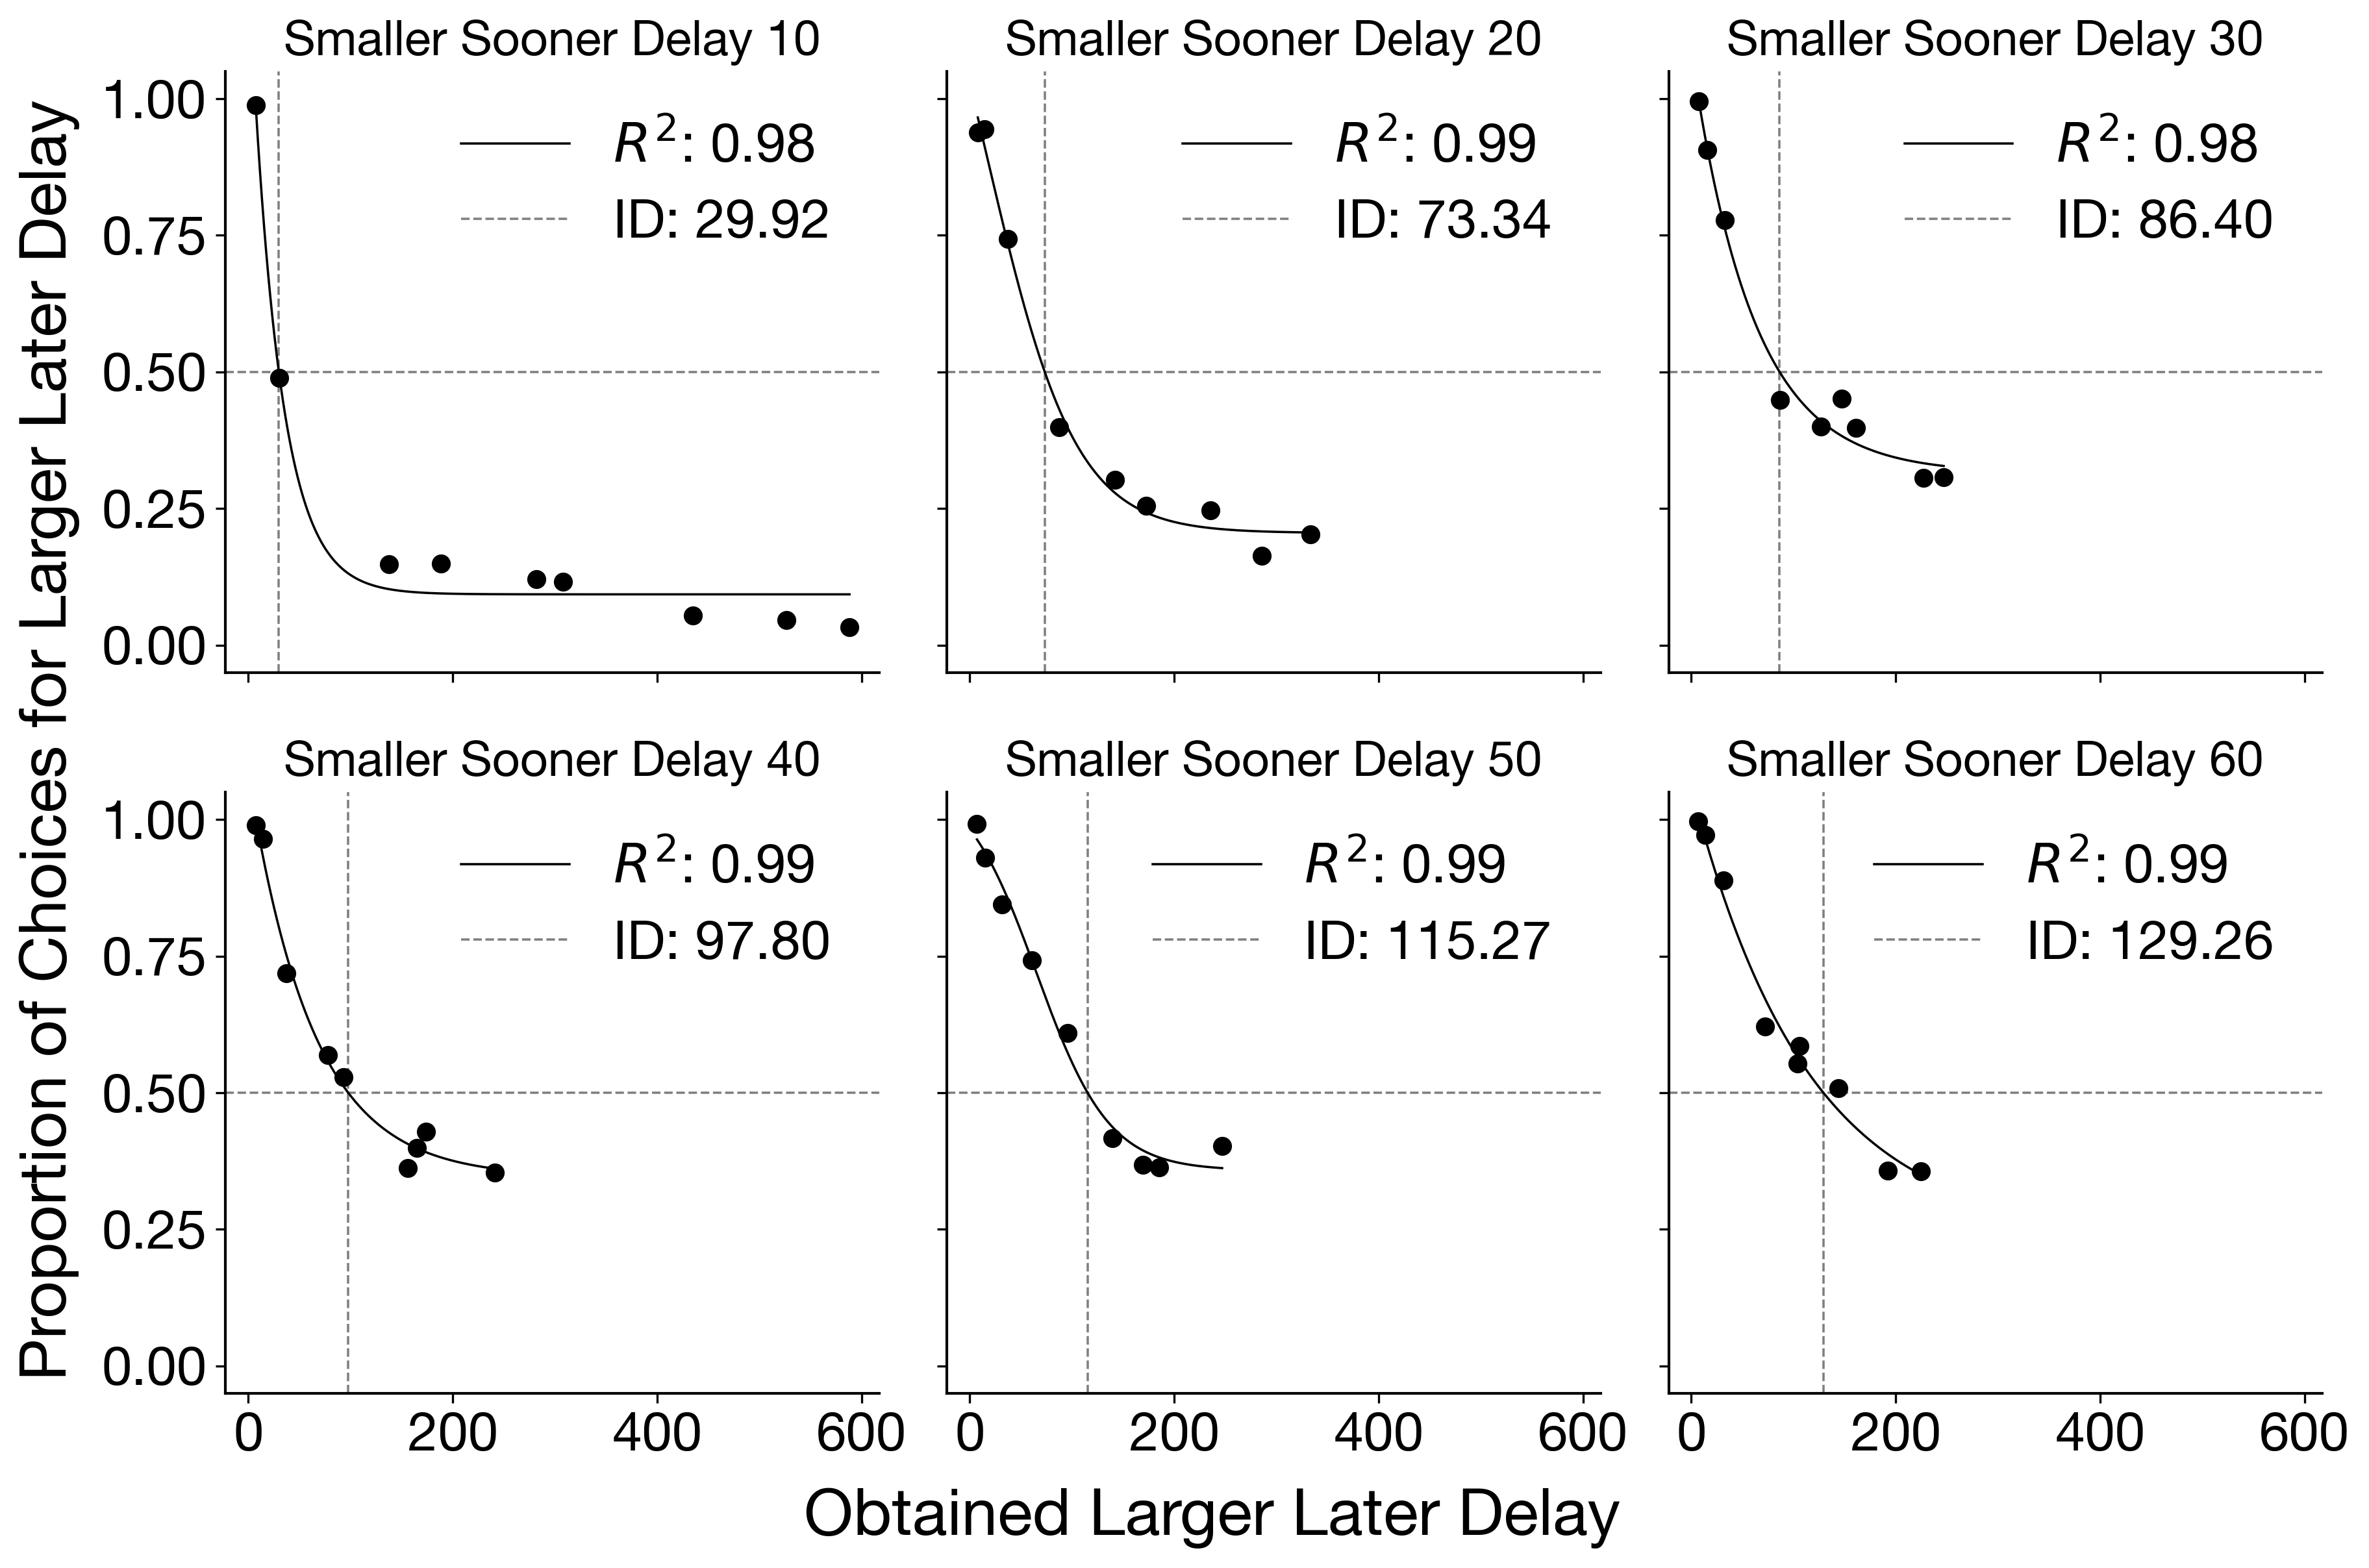

In [13]:
AO = 27

one_ao = ind_ao_df[ind_ao_df["Rep"] == AO]

fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, ssd in enumerate(one_ao["SSDelay"].unique()):
    df = one_ao[one_ao["SSDelay"] == ssd]
    ax = axs[i]

    obtained_delays = df["ObtainedLLDelay"].values
    props = df["PropLL"].values

    params, _ = curve_fit(sigmoid, obtained_delays, props, p0=[-0.9, 0.05, 100, 1], maxfev=1000000)

    res = props - sigmoid(obtained_delays, *params)
    ss_res = np.sum(res**2)
    ss_tot = np.sum((props - np.mean(props))**2)
    r2 = 1 - (ss_res / ss_tot)

    estimation_x = np.linspace(min(obtained_delays), max(obtained_delays), 10000)
    estimation_y = sigmoid(estimation_x, *params)

    indiff_delay = estimation_x[np.argmin(np.abs(estimation_y - 0.5))]

    ax.scatter(obtained_delays, props)
    ax.plot(estimation_x, estimation_y, lw=0.85, label = f"$R^2$: {r2:.2f}")
    ax.axhline(0.5, linestyle='--', lw=0.85, alpha=0.5)
    ax.axvline(indiff_delay, linestyle='--', lw=0.85, alpha=0.5, label=f"ID: {indiff_delay:.2f}")
    ax.set_title(f"Smaller Sooner Delay {int(ssd)}", size=18)
    ax.set_ylim(-0.05, 1.05)
    ax.legend()

fig.tight_layout()
fig.text(0.5, -0.01, "Obtained Larger Later Delay", ha='center', size=24)
fig.text(-0.01, 0.5, "Proportion of Choices for Larger Later Delay", va='center', rotation='vertical', size=24)

plt.savefig("outputs/experiment1/fig2.png", bbox_inches='tight')

plt.show()

    

## Discounting for One AO

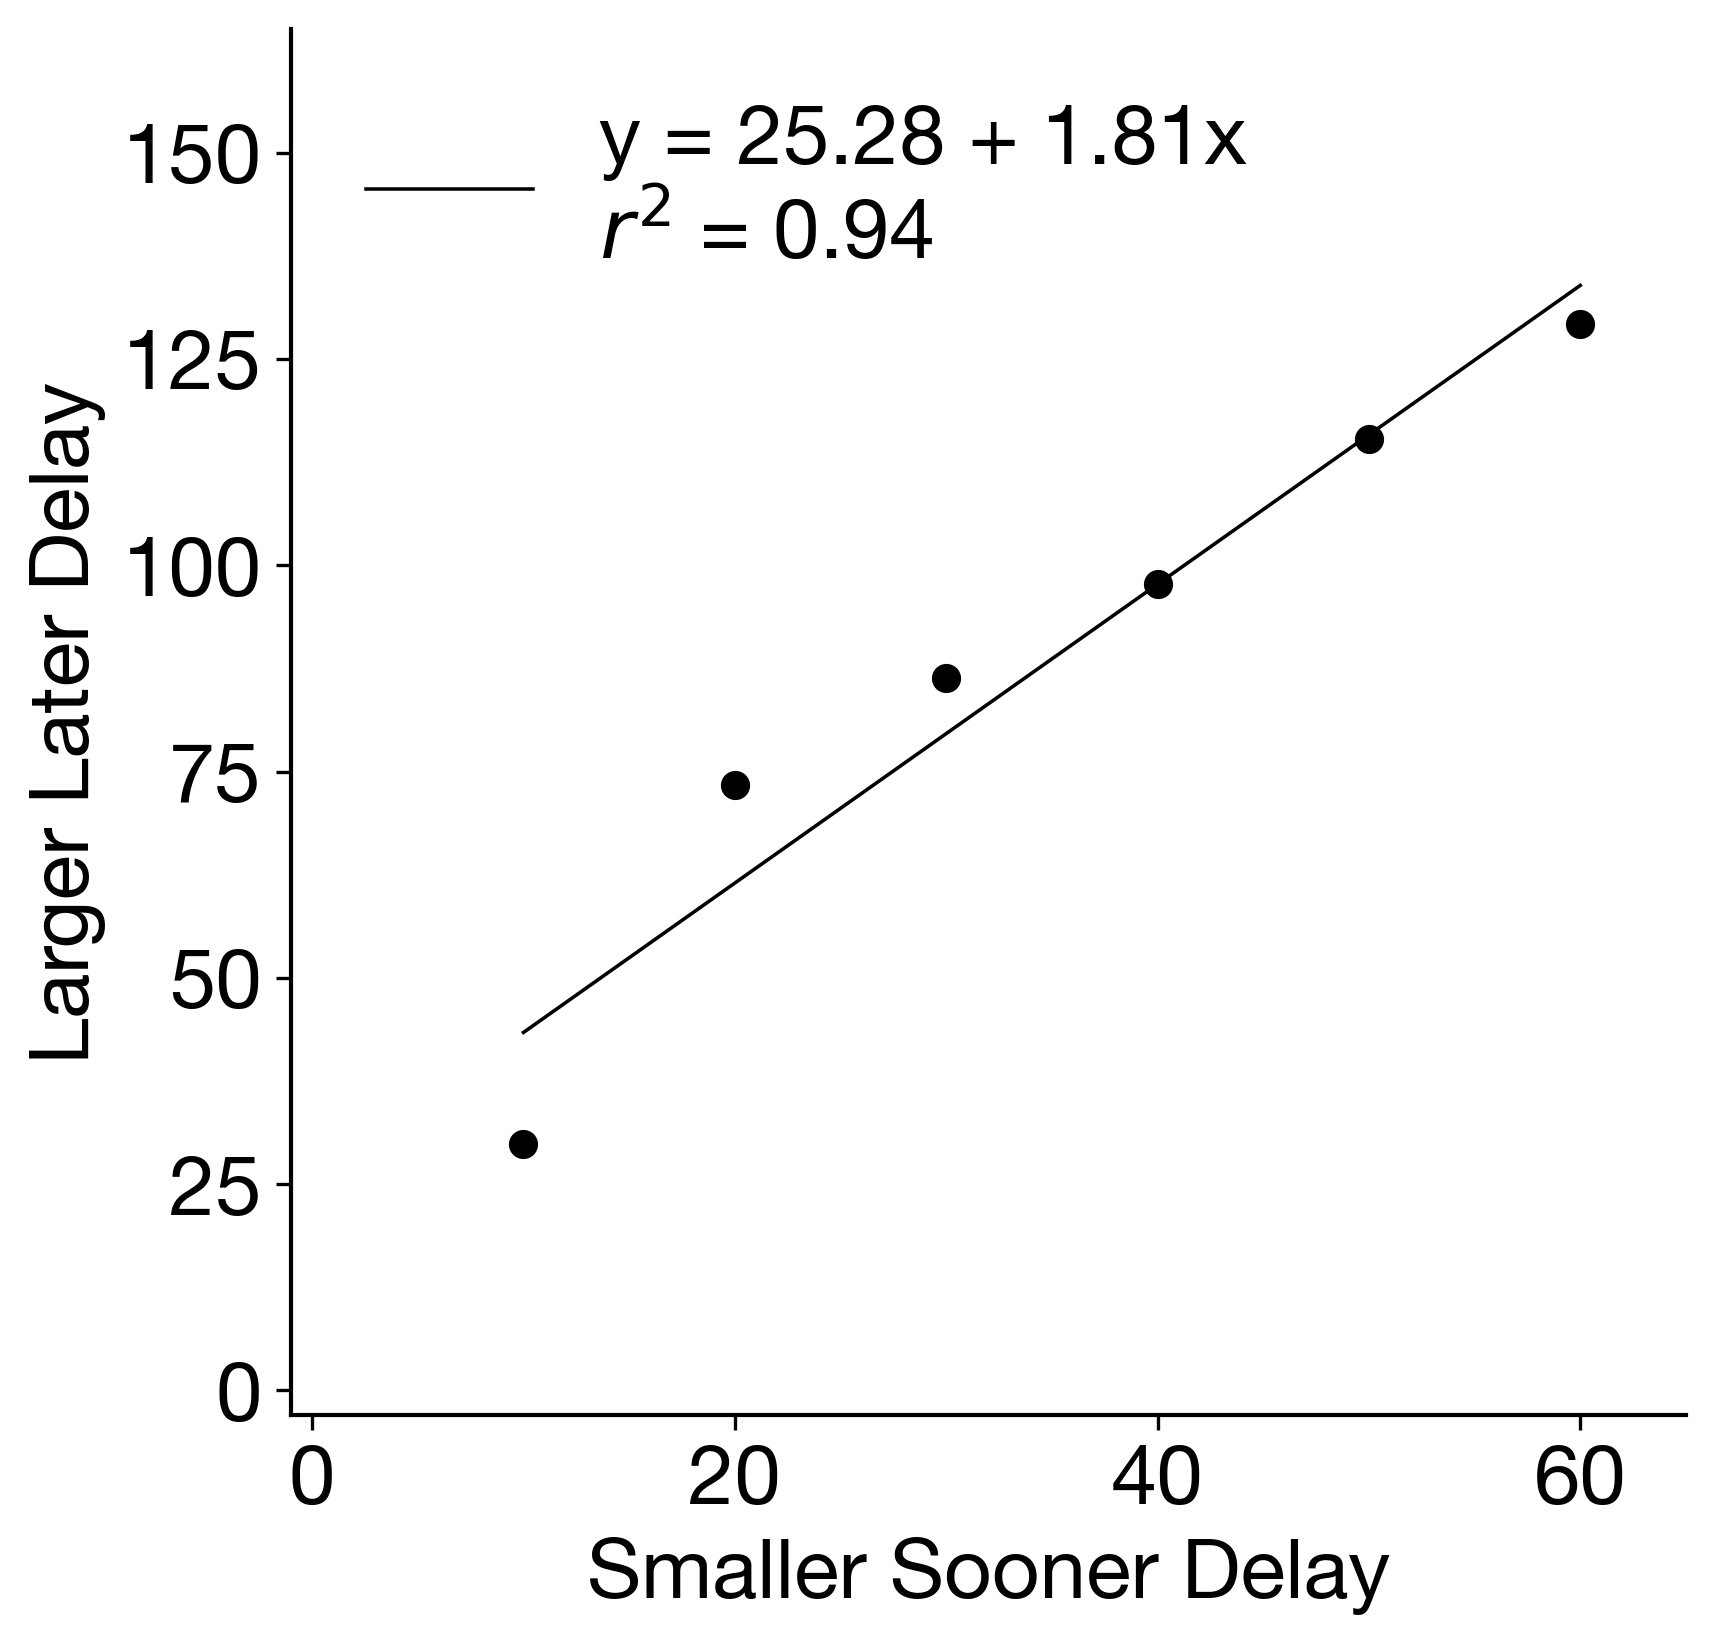

In [17]:
one_ao = ao_indiff_delays_df[ao_indiff_delays_df["Rep"] == AO]

fig, ax = plt.subplots()

x = one_ao["SS Delay"].values
y = one_ao["Indifference Delay"].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

ax.scatter(x, y)
ax.plot(x, slope*x + intercept, lw=0.85, label=f"y = {intercept:.2f} + {slope:.2f}x\n$r^2$ = {r_value**2:.2f}")
ax.set_xlabel("Smaller Sooner Delay", size=20)
ax.set_ylabel("Larger Later Delay", size=20)
ax.set_ylim(-3, 165)
ax.set_xlim(-1, 65)
ax.legend()

plt.savefig("outputs/experiment1/fig4.png", bbox_inches='tight')

plt.show()

## Indifference Delay Estimation for Average Data

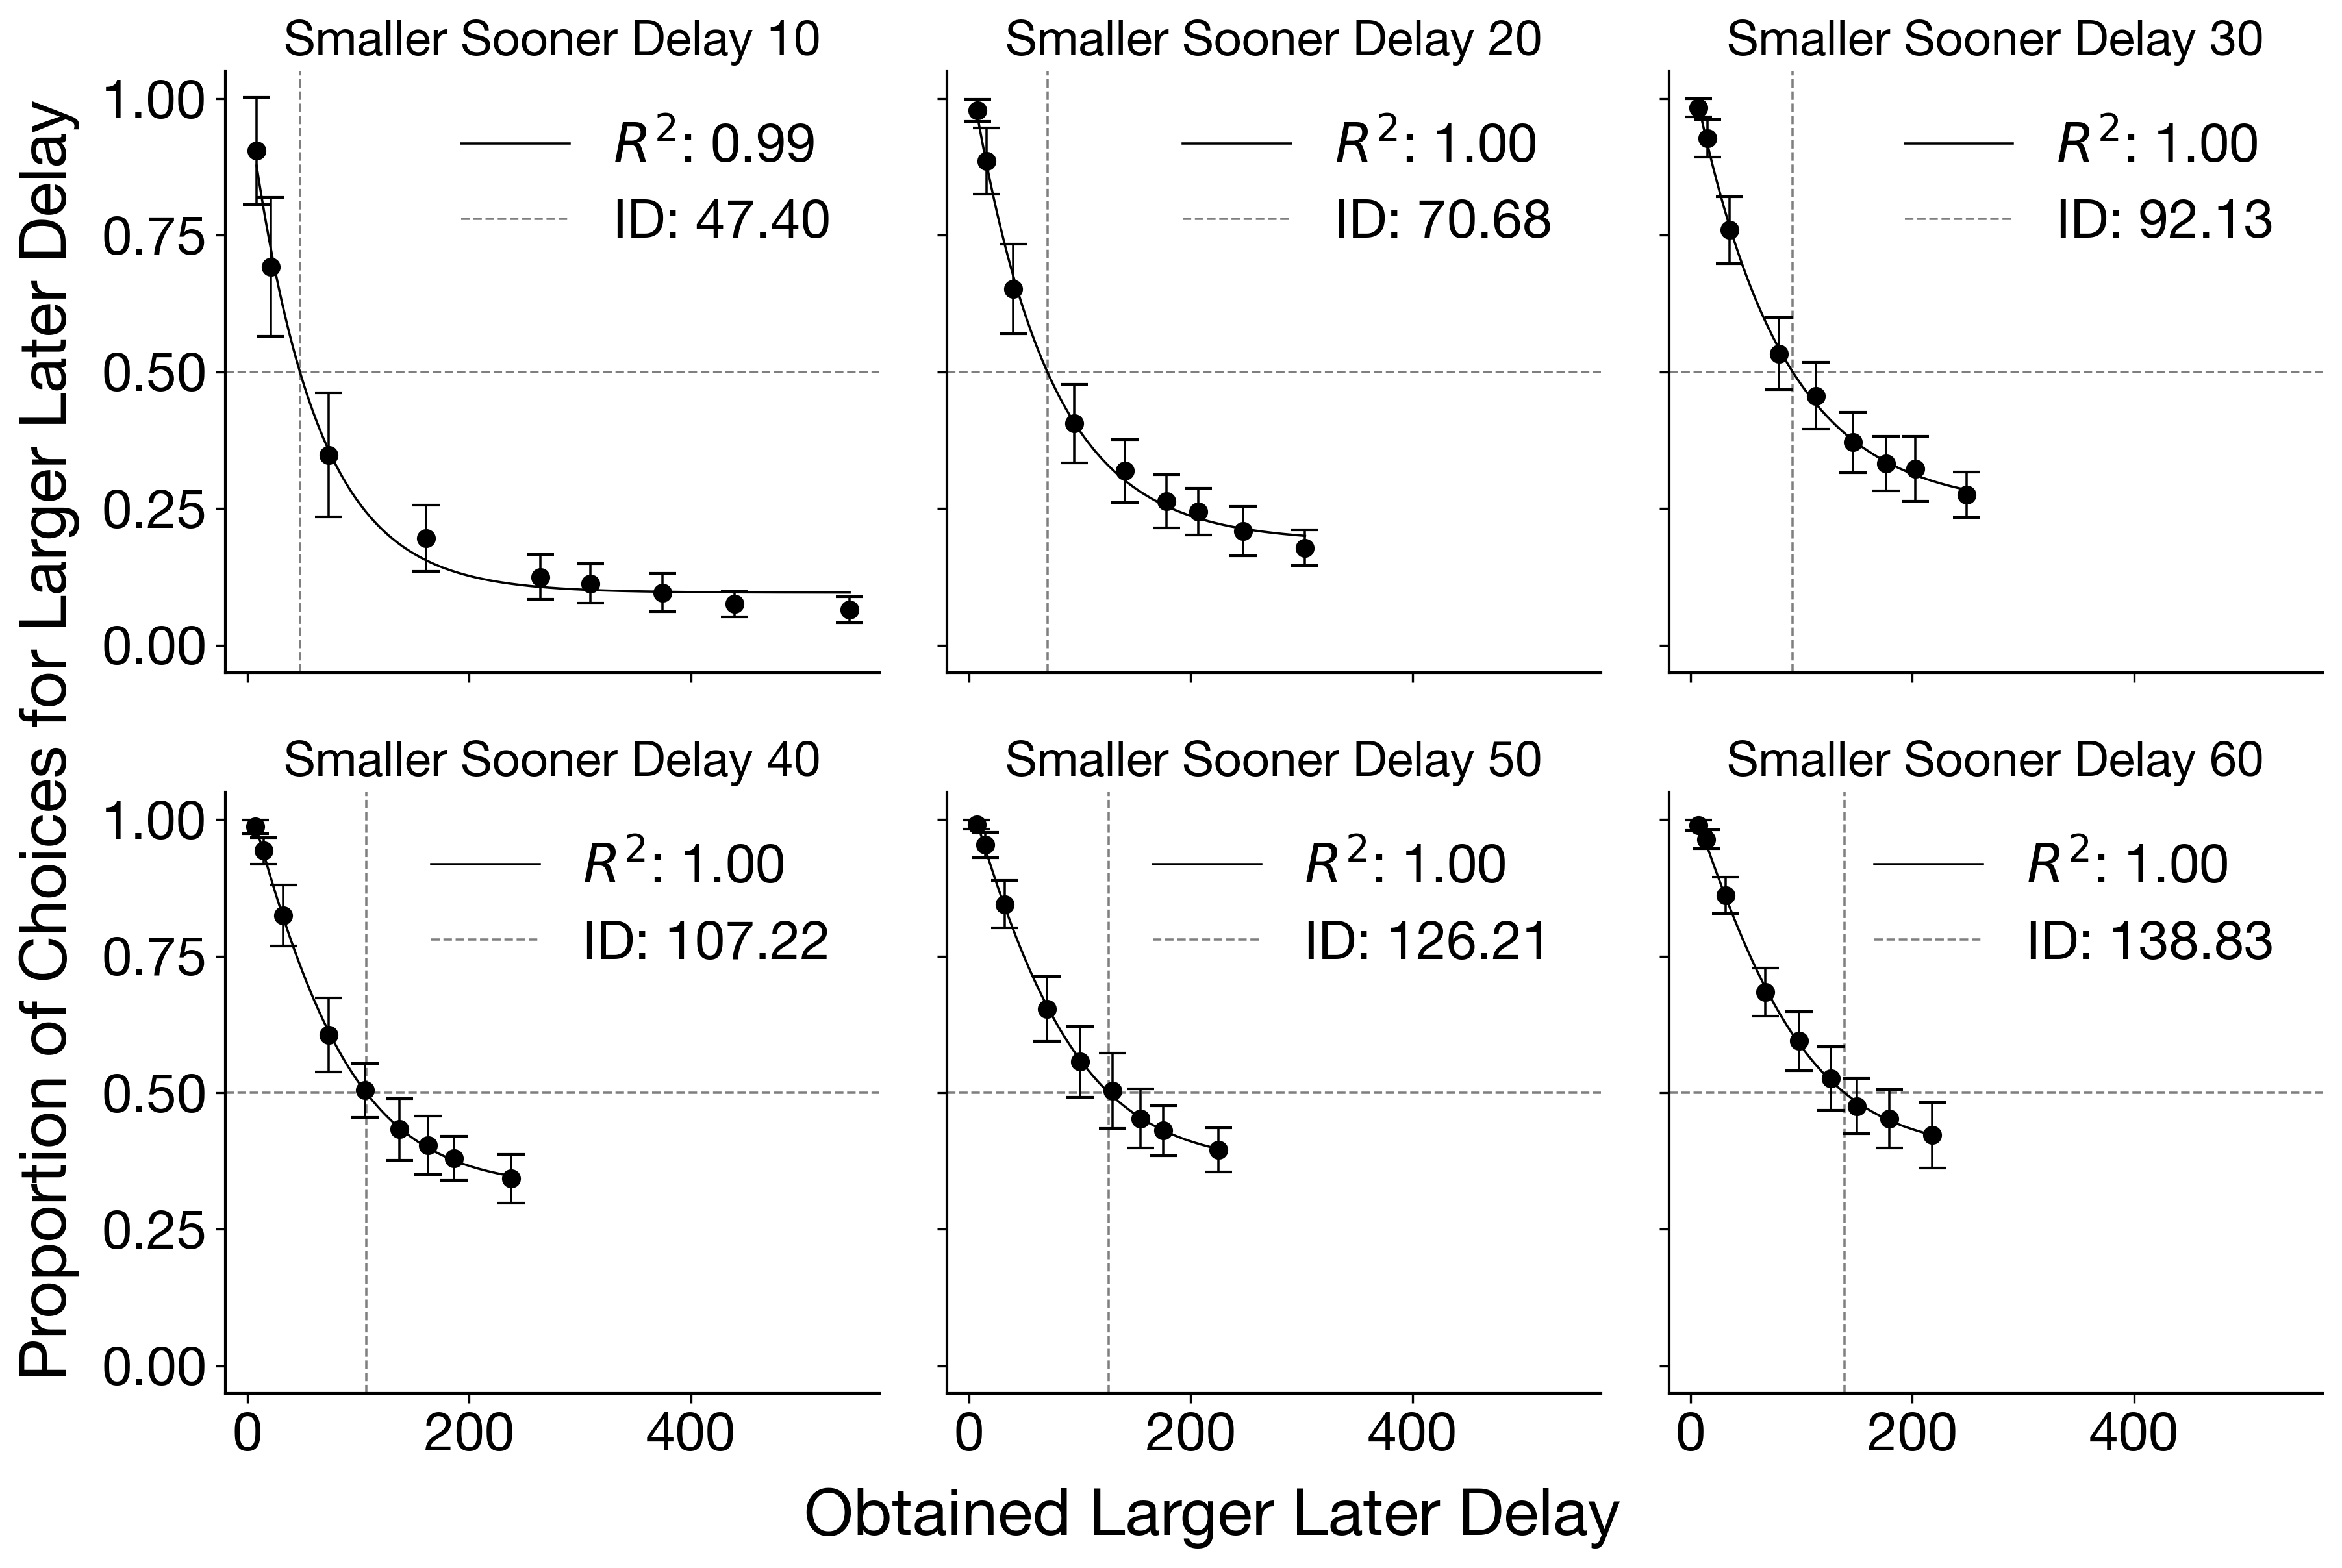

In [15]:
avg_indiff_delays = []

fig, axs = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()

for i, ssd in enumerate(avg_df[("SSDelay", "mean")].unique()):
    df = avg_df[avg_df[("SSDelay", "mean")] == ssd]
    ax = axs[i]

    obtained_delays = df[("ObtainedLLDelay", "mean")].values
    props = df[("PropLL", "mean")].values
    props_err = df[("PropLL", "std")].values

    params, _ = curve_fit(sigmoid, obtained_delays, props, p0=[-0.9, 0.05, 100, 1], maxfev=1000000)

    res = props - sigmoid(obtained_delays, *params)
    ss_res = np.sum(res**2)
    ss_tot = np.sum((props - np.mean(props))**2)
    r2 = 1 - (ss_res / ss_tot)

    estimation_x = np.linspace(min(obtained_delays), max(obtained_delays), 10000)
    estimation_y = sigmoid(estimation_x, *params)

    indiff_delay = estimation_x[np.argmin(np.abs(estimation_y - 0.5))]
    avg_indiff_delays.append(indiff_delay)

    ax.scatter(obtained_delays, props)
    ax.errorbar(obtained_delays, props, yerr=props_err, fmt='none', capsize=5, lw=0.85)
    ax.plot(estimation_x, estimation_y, lw=0.85, label = f"$R^2$: {r2:.2f}")
    ax.axhline(0.5, linestyle='--', lw=0.85, alpha=0.5)
    ax.axvline(indiff_delay, linestyle='--', lw=0.85, alpha=0.5, label=f"ID: {indiff_delay:.2f}")
    ax.set_title(f"Smaller Sooner Delay {int(ssd)}", size=18)
    ax.set_ylim(-0.05, 1.05)
    ax.legend()

fig.tight_layout()
fig.text(0.5, -0.01, "Obtained Larger Later Delay", ha='center', size=24)
fig.text(-0.01, 0.5, "Proportion of Choices for Larger Later Delay", va='center', rotation='vertical', size=24)

plt.savefig("outputs/experiment1/fig1.png", bbox_inches='tight')

plt.show()

    

## Discounting for Average Data

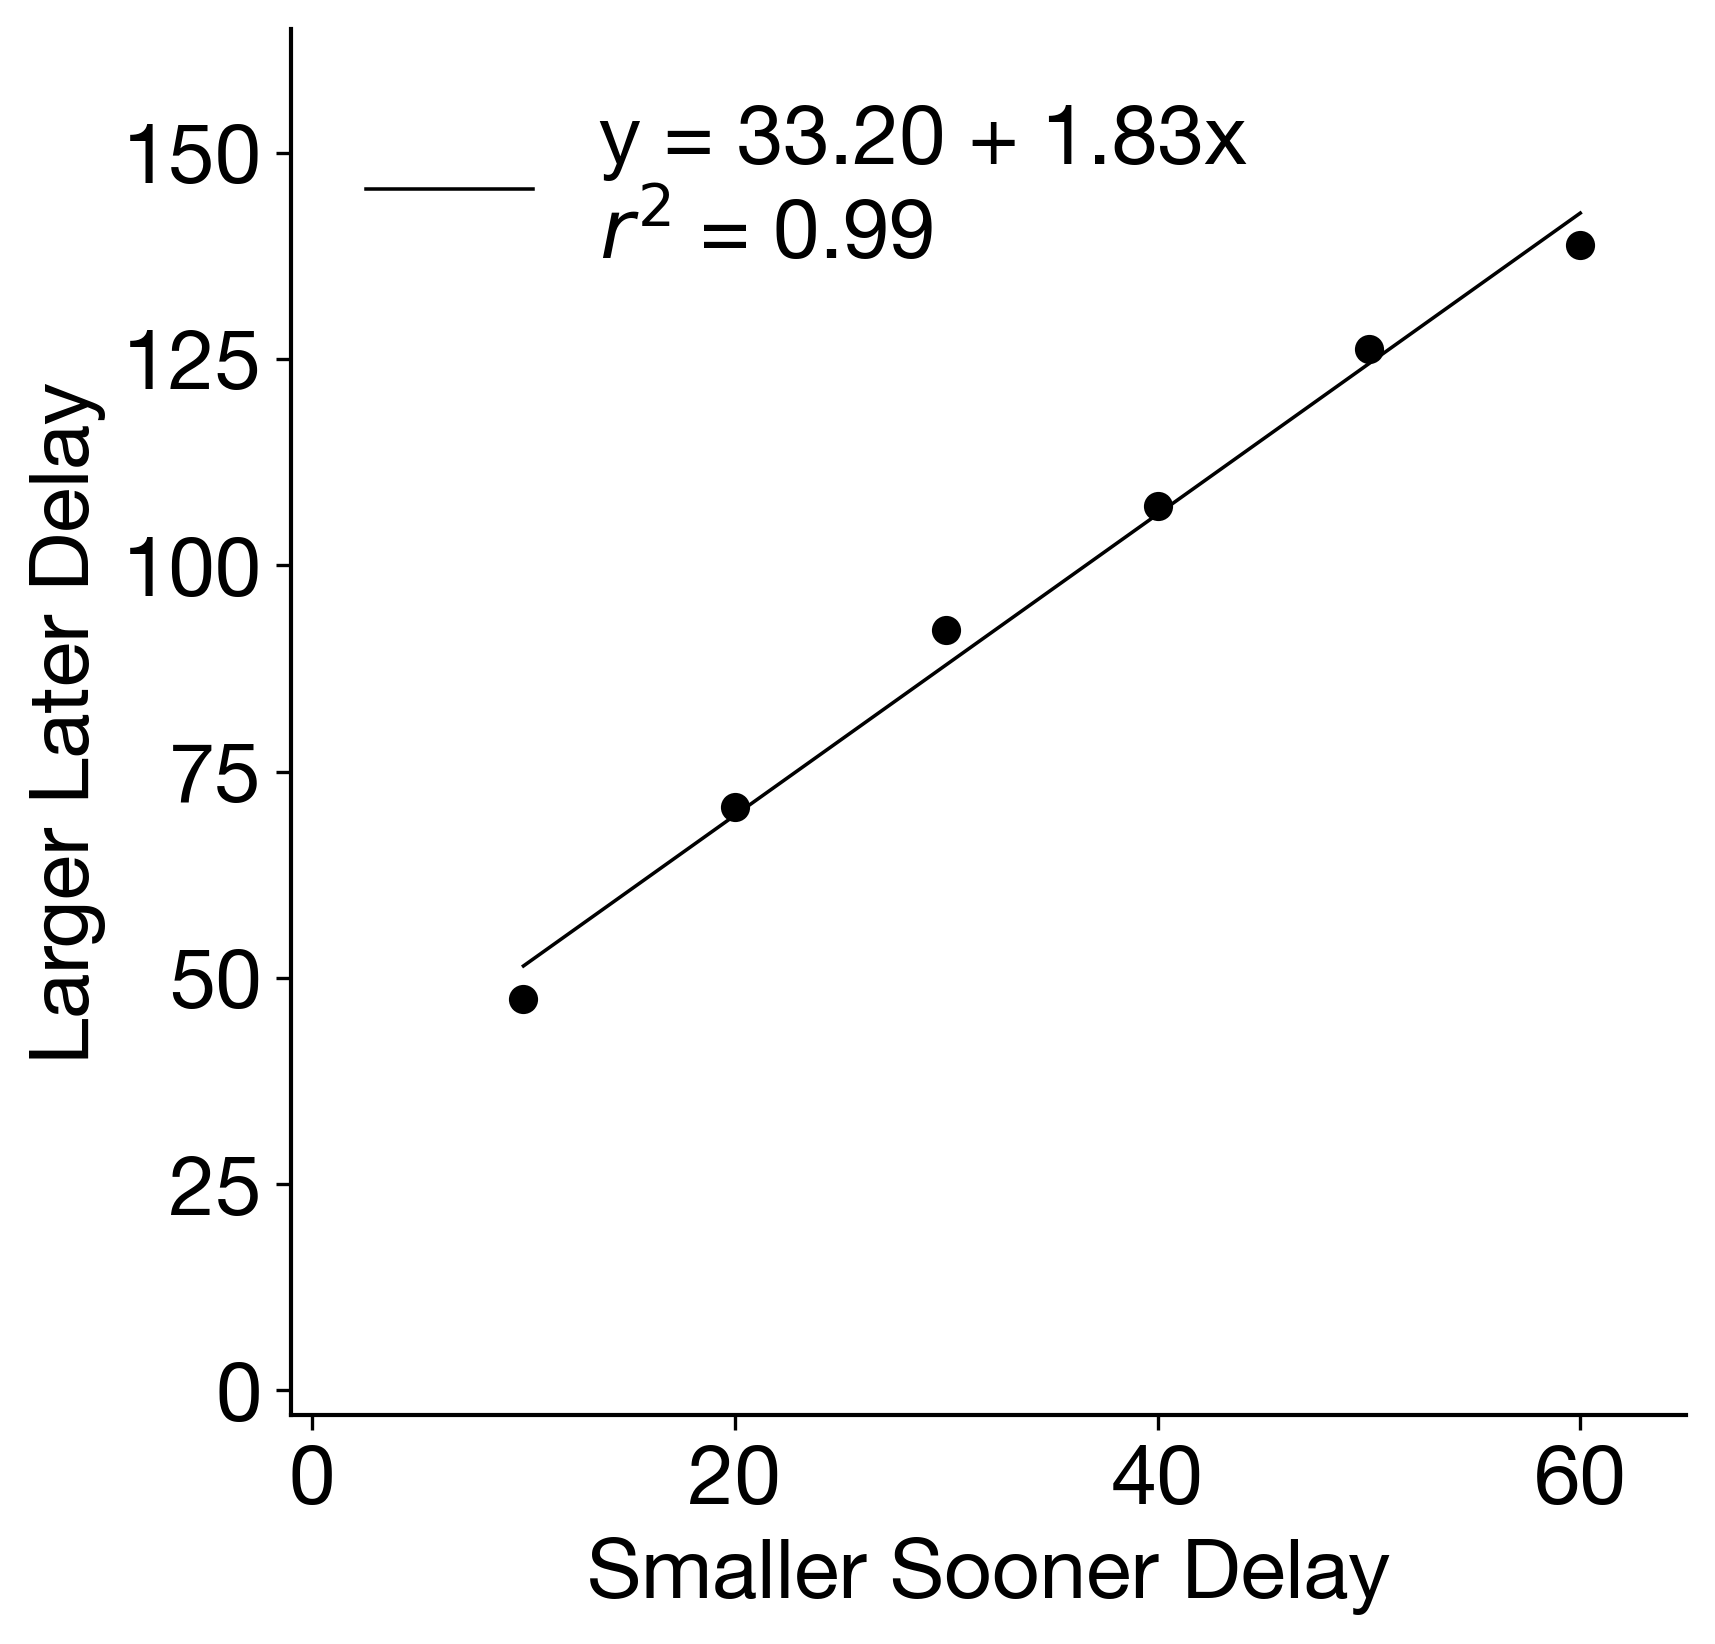

In [16]:
avg_indiff_delays = pd.DataFrame({
    "SS Delay": [10, 20, 30, 40, 50, 60],
    "Indifference Delay": avg_indiff_delays
})

fig, ax = plt.subplots()

x = avg_indiff_delays["SS Delay"].values
y = avg_indiff_delays["Indifference Delay"].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

ax.scatter(x, y)
ax.plot(x, slope*x + intercept, lw=0.85, label=f"y = {intercept:.2f} + {slope:.2f}x\n$r^2$ = {r_value**2:.2f}")
ax.set_xlabel("Smaller Sooner Delay", size=20)
ax.set_ylabel("Larger Later Delay", size=20)
ax.set_ylim(-3, 165)
ax.set_xlim(-1, 65)
ax.legend()

plt.savefig("outputs/experiment1/fig3.png", bbox_inches='tight')

plt.show()